In [ ]:
!nvidia-smi

Tue Jan  4 06:53:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    71W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

In [ ]:
model = VGG16(weights='imagenet')
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________

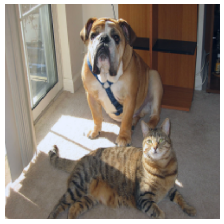

In [ ]:
img = image.load_img('/content/original.png',color_mode='rgb', target_size=(224, 224))
display(img)

In [ ]:
def preprocess(img):
    img = np.asarray(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    return img
image_1 = preprocess(img)

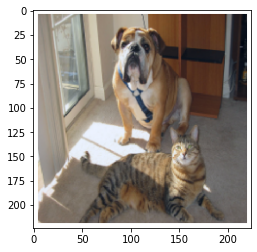

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [ ]:
predict = model.predict(image_1)
print(decode_predictions(predict,top=3))
target_class = np.argmax(predict[0])
print("Target Class = %d"%target_class)


[[('n02108422', 'bull_mastiff', 0.29576498), ('n02108089', 'boxer', 0.21160465), ('n02129604', 'tiger', 0.09686304)]]
Target Class = 243


In [ ]:
from keras import backend as K
import tensorflow as tf


In [ ]:
last_conv = model.get_layer('block5_conv3')
grads = K.gradients(model.output[:,242],last_conv.output)[0]

In [ ]:
pooled_grads = K.mean(grads,axis=(0,1,2))
iterate = K.function([model.input],[pooled_grads,last_conv.output[0]])
pooled_grads_value,conv_layer_output = iterate([image_1])

In [ ]:
for i in range(512):
    conv_layer_output[:,:,i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output,axis=-1)


(14, 14)


In [ ]:
for x in range(heatmap.shape[0]):
    for y in range(heatmap.shape[1]):
        heatmap[x,y] = np.max(heatmap[x,y],0)

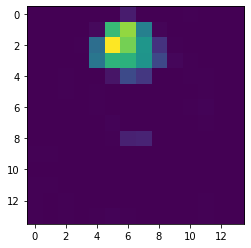

In [ ]:
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.imshow(heatmap)

In [ ]:
from skimage.transform import resize

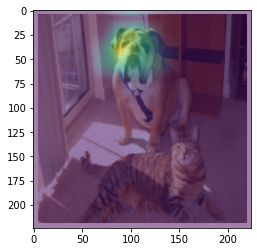

In [ ]:
upsample = resize(heatmap, (224,224),preserve_range=True)
plt.imshow(img)
plt.imshow(upsample,alpha=0.5)
plt.show()